In [1]:
import os, sys
from pathlib import Path

output = !dirname $(pwd)
# detect:
PROJECT_ROOT_PATH = output[0]
# or custom path:
# PROJECT_ROOT_PATH = "~/work/washu"
sys.path.insert(0, os.path.expanduser(PROJECT_ROOT_PATH))

In [2]:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np 


In [3]:
import reports.bed_metrics as bm
import reports.loci_of_interest as loi

------------------------------

In [4]:
results_dir = Path("/mnt/stripe/bio/experiments/aging/loci_of_interest")
# THREADS_N = 32

# results_dir = Path("/Volumes/BigData/bio/experiments/aging/loci_of_interest.tables")
THREADS_N = 8

results_dir.mkdir(exist_ok=True)

# Cleanup

In [5]:
# !rm -rf {sorted_root}

# Known annotations

In [6]:
# data_root = Path("/Volumes/BigData/bio")
data_root = Path("/mnt/stripe/bio")

loci_root = data_root / "raw-data/aging/loci_of_interest"
signal_root = data_root / "experiments/signal"

exclude_outliers = False
golden_peaks_root = data_root / "experiments/aging/peak_calling"
zinbra_peaks_root = data_root / "experiments/configs/Y20O20{}/peaks".format(
    "" if exclude_outliers else "_full"
)


In [7]:
loi_dict = loi.collect_loci(loci_root)
sorted([str(k) for k in loi_dict.keys()])

['None',
 'chipseq_diff_loci',
 'chromhmm',
 'conservation',
 'default',
 'enhancers',
 'golden_consensus',
 'golden_median_consensus',
 'interesting_pathways',
 'od_yd_difference_regions',
 'other_pathways',
 'regulatory',
 'repeats',
 'rna_diff',
 'tfs',
 'zinbra_consensus',
 'zinbra_median_consensus']

In [8]:
!ls {loci_root}

cd14_enhancer_atlas_CD14+.hg19.bed
chipseq_diff_loci
chromhmm
conservation
cpg_clock_1000_hg19.bed
cpg_clock_hg19.bed
cpg_islands_clock_hg19.bed
enhancers
golden_consensus
golden_median_consensus
interesting_pathways
lengths.csv
mirna_human.bed
od_yd_difference_regions
other_pathways
regulatory
repeats
rna_diff
tfs
ucne_conserved_coord.hg19.bed
ucsc_cpgIslandExt.hg19.bed
washu_german_rrbs_filtered_dmrs_all_10.hg19.bed
zinbra_consensus
zinbra_median_consensus


In [9]:
!ls {zinbra_peaks_root}

H3K27ac                       H3K36me3_zinbra_2000.pdf
H3K27ac_peaks_plots.pdf       H3K36me3_zinbra_all.pdf
H3K27ac_zinbra.pdf            H3K36me3_zinbra_all_10000.pdf
H3K27ac_zinbra_15000.pdf      H3K4me1
H3K27ac_zinbra_8500.pdf       H3K4me1_peaks_plots.pdf
H3K27ac_zinbra_all.pdf        H3K4me1_zinbra.pdf
H3K27ac_zinbra_all_15000.pdf  H3K4me1_zinbra_30000.pdf
H3K27me3                      H3K4me1_zinbra_all.pdf
H3K27me3_peaks_plots.pdf      H3K4me1_zinbra_all_30000.pdf
H3K27me3_zinbra.pdf           H3K4me3
H3K27me3_zinbra_1000.pdf      H3K4me3_peaks_plots.pdf
H3K27me3_zinbra_5000.pdf      H3K4me3_zinbra.pdf
H3K27me3_zinbra_all.pdf       H3K4me3_zinbra_2500.pdf
H3K27me3_zinbra_all_5000.pdf  H3K4me3_zinbra_5000.pdf
H3K36me3                      H3K4me3_zinbra_all.pdf
H3K36me3_peaks_plots.pdf      H3K4me3_zinbra_all_5000.pdf
H3K36me3_zinbra.pdf           Y20O20_full.yaml
H3K36me3_zinbra_10000.pdf


In [10]:
!ls {golden_peaks_root}

H3K27ac                          custom_macs_narrow_peaks_frip.sh
H3K27me3                         custom_sicer_peaks_frip.sh
H3K36me3                         enhancers
H3K4me1                          intersection.pdf
H3K4me3                          intersection_.pdf
H3K4me3.pdf                      median_cons.sh
benchmark_peaks                  search_results_test2.csv
cpg_islands_clock_hg19.bed       weak_cons.sh


## ChromHMM

In [11]:
for i, p in enumerate(loi_dict["chromhmm"]):
    print(loi.chromhmm_state_descr(p.name), "->", p)

1_TssA (Active TSS) -> /mnt/stripe/bio/raw-data/aging/loci_of_interest/chromhmm/cd14_chromhmm.hg19.1_TssA.bed
2_TssFlnk (Flanking TSS) -> /mnt/stripe/bio/raw-data/aging/loci_of_interest/chromhmm/cd14_chromhmm.hg19.2_TssFlnk.bed
3_TssFlnkU (Flanking TSS Upstream) -> /mnt/stripe/bio/raw-data/aging/loci_of_interest/chromhmm/cd14_chromhmm.hg19.3_TssFlnkU.bed
4_TssFlnkD (Flanking TSS Downstream) -> /mnt/stripe/bio/raw-data/aging/loci_of_interest/chromhmm/cd14_chromhmm.hg19.4_TssFlnkD.bed
5_Tx (Strong transcription) -> /mnt/stripe/bio/raw-data/aging/loci_of_interest/chromhmm/cd14_chromhmm.hg19.5_Tx.bed
6_TxWk (Weak transcription) -> /mnt/stripe/bio/raw-data/aging/loci_of_interest/chromhmm/cd14_chromhmm.hg19.6_TxWk.bed
7_EnhG1 (Genic enhancer1) -> /mnt/stripe/bio/raw-data/aging/loci_of_interest/chromhmm/cd14_chromhmm.hg19.7_EnhG1.bed
8_EnhG2 (Genic enhancer2) -> /mnt/stripe/bio/raw-data/aging/loci_of_interest/chromhmm/cd14_chromhmm.hg19.8_EnhG2.bed
9_EnhA1 (Active Enhancer 1) -> /mnt/stripe/b

## Default Loci

Cannot include all files from dir, because list is too big and heatmap becomes unreadable. Let's keep curated list
of loci by rules:
* root folder top level *.bed files
* subfoldes: "enchancers", "tfs", "regulatory", "weak_median_consensus", "zinbra_median_consensus"

In [12]:
loi_dict["default"]

[PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/CTCF.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K27acDist10kbTssNotIntCTCF.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K27acDist3kbTss.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K4me1Dist10kbTss.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K4me1Dist1kbTss.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K4me1Dist3kbTssNotIntCTCF.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K4me1IntK27ac.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K4me1IntK27acDist10kbTss.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K4me1IntK27acDist3kbTssNotIntCTCF.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/chromhmm/cd14_chromhmm.hg19.10_EnhA2.bed'),
 PosixPath('/mnt/stripe

## Peaks

In [13]:
peaks_dict = {
    "zinbra": loi._collect_zinbra_peaks(zinbra_peaks_root),
    "golden": loi._collect_golden_peaks(golden_peaks_root, exclude_outliers)
}

In [15]:
def peaks_info(peaks_dict, tool):
    tool_peaks_dict = peaks_dict[tool]
    for hist in sorted(tool_peaks_dict.keys()):
        peaks = tool_peaks_dict[hist]
        print("Peaks:", hist, len(peaks))
        #print("\n".join(str(f) for f in peaks))    

In [16]:
peaks_info(peaks_dict, "golden")

Peaks: H3K27ac 40
Peaks: H3K27me3 40
Peaks: H3K36me3 39
Peaks: H3K4me1 32
Peaks: H3K4me3 40


In [17]:
peaks_info(peaks_dict, "zinbra")

Peaks: H3K27ac 40
Peaks: H3K27me3 40
Peaks: H3K36me3 39
Peaks: H3K4me1 32
Peaks: H3K4me3 40


## Consensus

In [18]:
# loi_dict["zinbra_consensus"]
loi_dict["zinbra_median_consensus"]

[PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/zinbra_median_consensus/H3K27ac_zinbra_ODS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/zinbra_median_consensus/H3K27ac_zinbra_ODS_without_YDS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/zinbra_median_consensus/H3K27ac_zinbra_YDS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/zinbra_median_consensus/H3K27ac_zinbra_YDS_without_ODS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/zinbra_median_consensus/H3K27ac_zinbra_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/zinbra_median_consensus/H3K27me3_zinbra_ODS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/zinbra_median_consensus/H3K27me3_zinbra_ODS_without_YDS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/zinbra_median_con

In [19]:
#loi_dict["golden_consensus"]
loi_dict["golden_median_consensus"]

[PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/golden_median_consensus/H3K27ac_golden_ODS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/golden_median_consensus/H3K27ac_golden_ODS_without_YDS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/golden_median_consensus/H3K27ac_golden_YDS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/golden_median_consensus/H3K27ac_golden_YDS_without_ODS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/golden_median_consensus/H3K27ac_golden_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/golden_median_consensus/H3K27me3_golden_ODS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/golden_median_consensus/H3K27me3_golden_ODS_without_YDS_median_consensus.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/golden_median_con

# Code

In [33]:
def process_intersection_metric(a_paths, b_paths, df_path: Path,
                                col_label_converter=loi.label_converter_shorten_loci,
                                row_label_converter=loi.label_converter_shorten_loci,
                                **kw):
    df = bm.load_or_build_metrics_table(a_paths, b_paths, df_path, threads=THREADS_N, **kw)

    # print to pdf:
    bm.plot_metric_heatmap("IM: {}".format(df_path.name), df, 
                           col_label_converter=col_label_converter,
                           row_label_converter=row_label_converter,
                           **kw)
    return df

# TMP

In [20]:
!rm {results_dir}/tmp0_loci*

rm: /mnt/stripe/bio/experiments/aging/loci_of_interest/tmp0_loci*: No such file or directory


In [21]:
tmp_loci_paths = loi_dict["default"][0:6]
tmp_loci_paths

[PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/CTCF.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K27acDist10kbTssNotIntCTCF.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K27acDist3kbTss.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K4me1Dist10kbTss.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K4me1Dist1kbTss.bed'),
 PosixPath('/mnt/stripe/bio/raw-data/aging/loci_of_interest/enhancers/K4me1Dist3kbTssNotIntCTCF.bed')]

[Skipped]: Already exists /mnt/stripe/bio/experiments/aging/loci_of_interest/tmp0_loci.csv


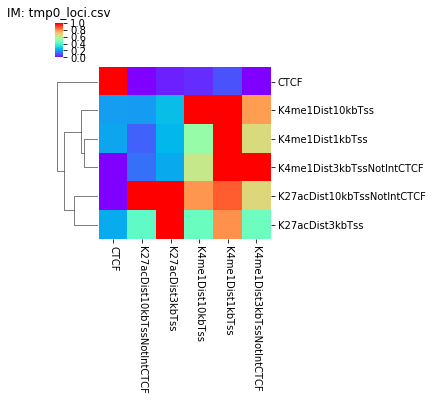

In [31]:
process_intersection_metric(tmp_loci_paths, tmp_loci_paths, results_dir / "tmp0_loci.csv",
                            row_cluster=True, col_cluster=False,
                            figsize=(5,5))
None

# Chose Metrics

In [27]:
paths = [loci_root / fname for fname in (
    "ucsc_cpgIslandExt.hg19.bed", 
    "ucne_conserved_coord.hg19.bed", 
    "washu_german_rrbs_filtered_dmrs_all_10.hg19.bed", 
    "cpg_islands_clock_hg19.bed",
    "cpg_clock_1000_hg19.bed"
)]
paths.extend(loi_dict["regulatory"])
paths.extend(loi_dict["golden_median_consensus"])
len(paths)

44

/Users/romeo/anaconda/envs/aging3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


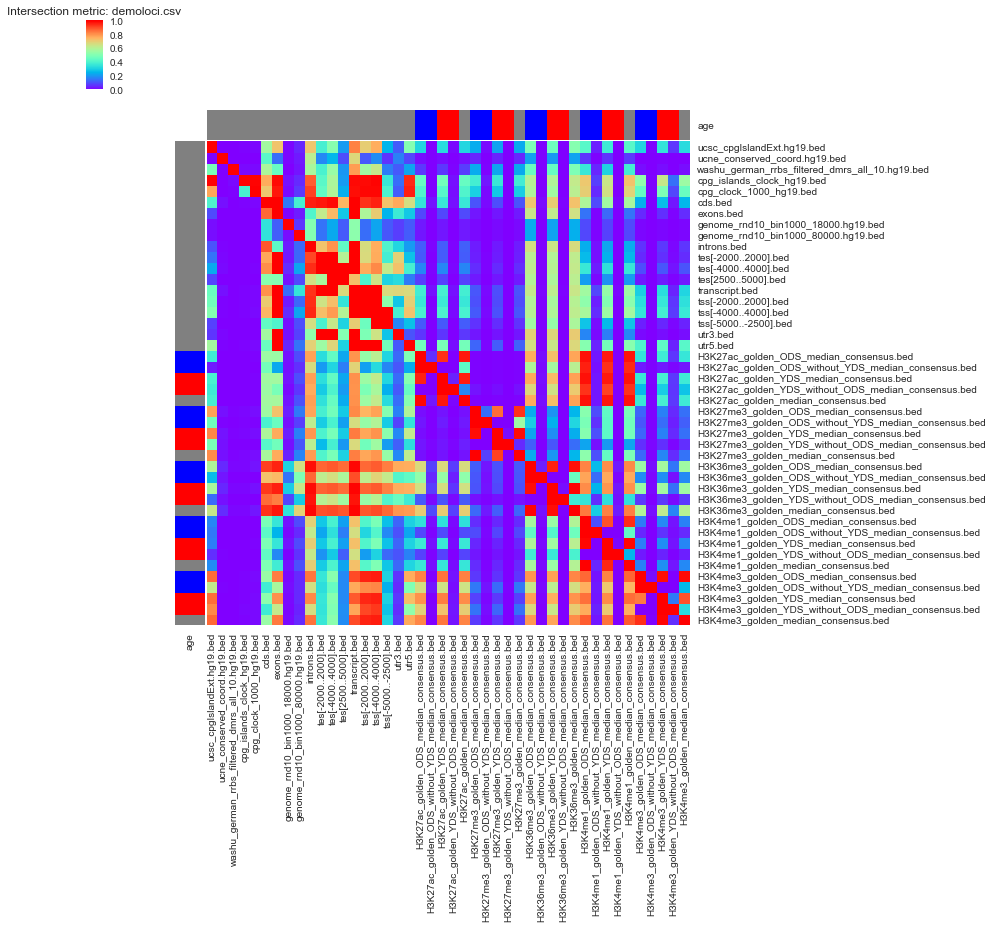

In [29]:
process_intersection_metric(paths, paths, results_dir / "demoloci.csv", 
                            row_cluster=False, col_cluster=False,
                            figsize=(15,15))
None

/Users/romeo/anaconda/envs/aging3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


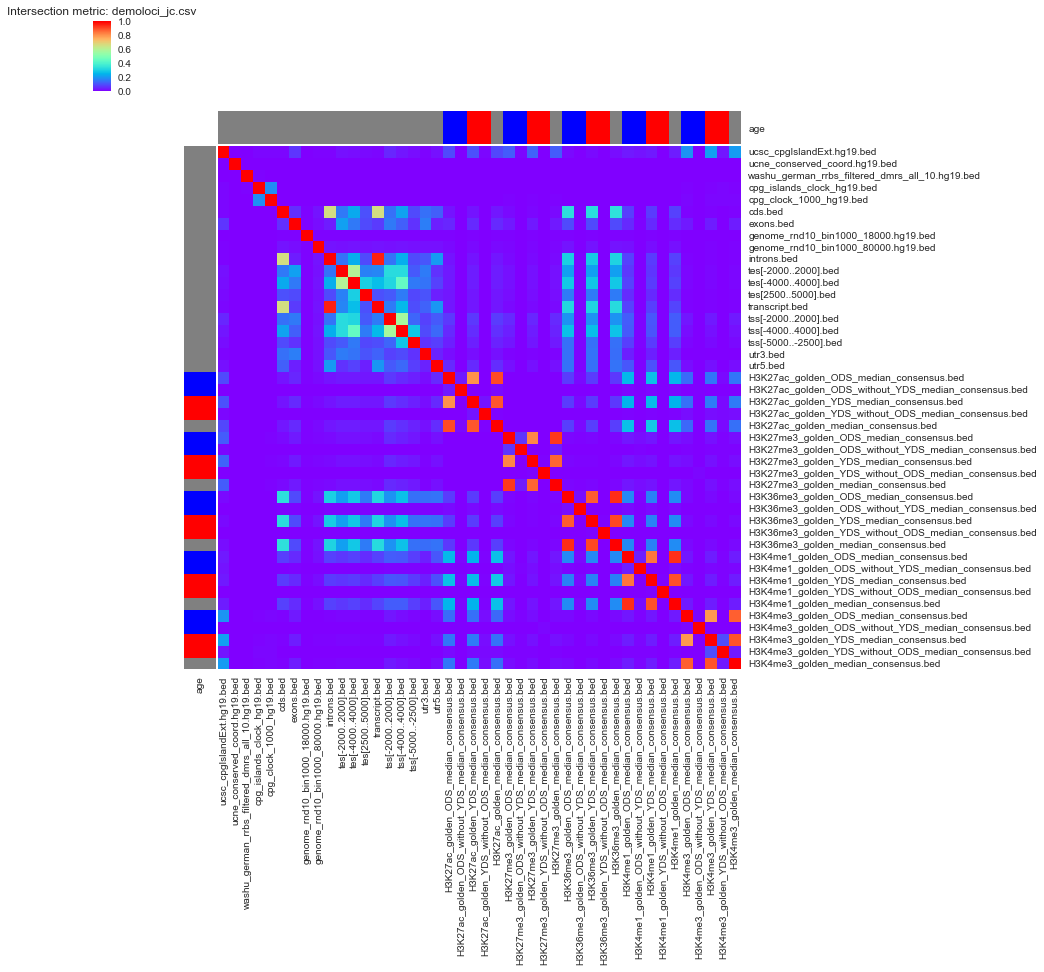

In [30]:
process_intersection_metric(paths, paths, results_dir / "demoloci_jc.csv", jaccard=True, 
                            row_cluster=False, col_cluster=False,
                            figsize=(15,15))
None

# Peaks

Peaks building extracted to report `./reports/loci_intersection_report.py`. This section is now a playground.

## Demo loci vs Loci


/Users/romeo/anaconda/envs/aging3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


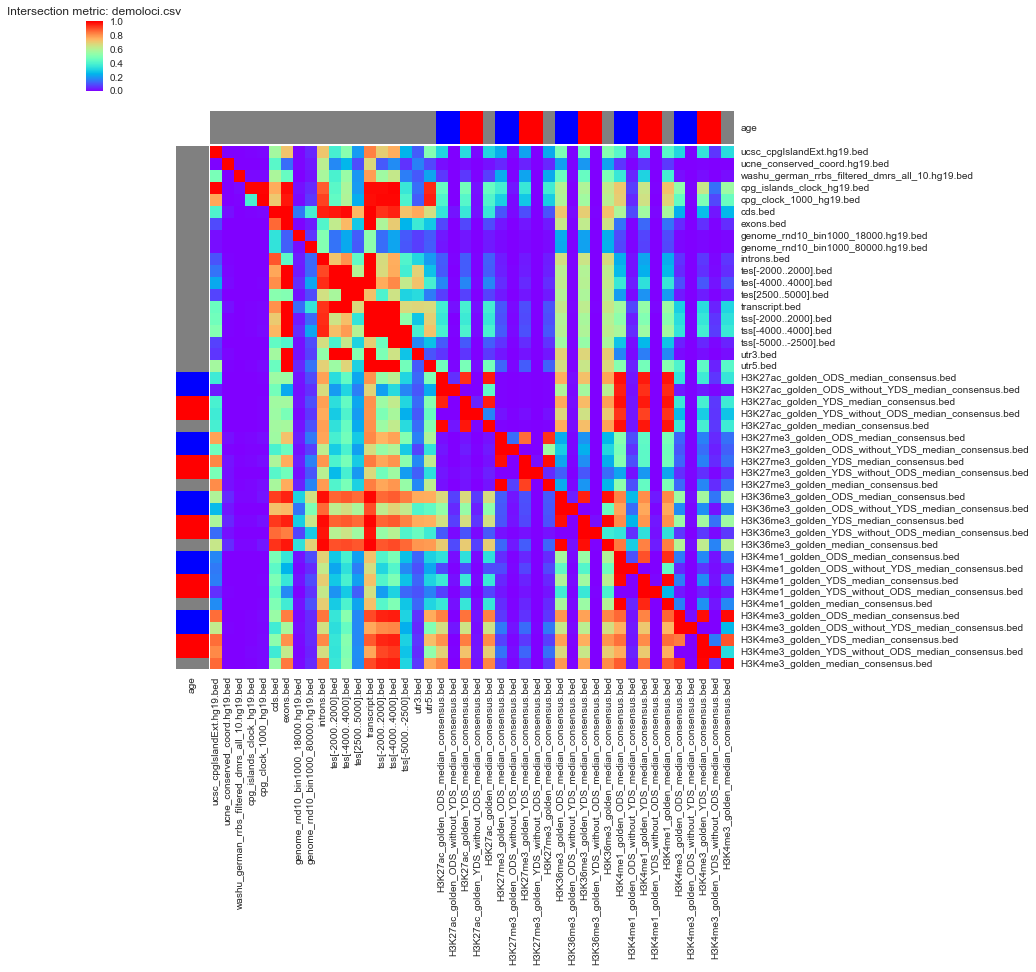

In [31]:
paths = [loci_root / fname for fname in (
    "ucsc_cpgIslandExt.hg19.bed", 
    "ucne_conserved_coord.hg19.bed", 
    "washu_german_rrbs_filtered_dmrs_all_10.hg19.bed", 
    "cpg_islands_clock_hg19.bed",
    "cpg_clock_1000_hg19.bed"
)]
paths.extend(loi_dict["regulatory"])
paths.extend(loi_dict["golden_median_consensus"])

process_intersection_metric(paths, paths, results_dir / "demoloci.csv", 
                            row_cluster=False, col_cluster=False,
                            figsize=(15,15))
None

# Coverage (Signal)

In [ ]:
signal_root

In [ ]:
signals_results_dir = results_dir / "signals"

## Plots

In [ ]:
! rm -rf {signals_results_dir}

In [ ]:
if signals_results_dir.exists():
    # TODO: load
    pass
else:
    signal_dfs_by_datatype = {}
    signal_dfs_by_loci = {}
    missed_files = []

    signals_results_dir.mkdir(exist_ok=True, parents=True)
    
    series_by_loci = defaultdict(list)
    data_type_paths = [p for p in signal_root.iterdir() if p.is_dir()]
    for i, data_type_path in enumerate(data_type_paths, 1):
        data_type = data_type_path.name
        print("[{}/{}] Processing: {}".format(i, len(data_type_paths), data_type))

        for norm in ["raw", "rpkm", "rpm"]:
            print("  Normalization:", norm)
            series_by_datatype = []

            # TODO: load from results dir?
            for loci_path in (p for p in data_type_path.iterdir() if p.is_dir()):
                loci = loci_path.name
                files = [p for p in loci_path.glob("**/*_{}_data.csv".format(norm))]

                assert len(files) <= 1, "{}@{} [{}] Expected one file, but was {}: {}".format(
                    data_type, loci, norm, len(files), files
                )
                if not len(files):
                    missed_files.append("{}@{} [{}]".format(data_type, loci, norm))
                    continue

                df = pd.DataFrame.from_csv(files[0] , header=None)
                series = df.iloc[:,0]
                series.name = loci

                series_by_datatype.append(series) 

                series2 = series.copy()
                series2.name = data_type
                series_by_loci[(loci, norm)].append(series2)

            if len(series_by_datatype):
                # by data type:    
                df = pd.DataFrame(series_by_datatype, )
                #df.index = [f.stem for f in itertools.islice(files, 10)]

                df.to_csv(str(signals_results_dir / "signal_{}_{}.csv".format(data_type, norm)))
            else:
                df = None
            signal_dfs_by_datatype[(data_type, norm)] = df

    for (loci, norm), series in series_by_loci.items():
        if len(series):
            df = pd.DataFrame(series, )
            df.to_csv(str(signals_results_dir / "signal_{}_{}".format(loci, norm)))
        else:
            df = None
        signal_dfs_by_loci[(loci, norm)] = df
        
    print("Missed files: ", len(missed_files))
    print("  first 10:", *missed_files[0:10])
    print("Signal by datatype, missed records:", str(sum(1 for v in signal_dfs_by_datatype.values() if v is None)))
    print("  ", [k for k,v in signal_dfs_by_datatype.items() if v is None])
    print("Signal by loci, missed records:", str(sum(1 for v in signal_dfs_by_loci.values() if v is None)))    
    print("  ", [k for k,v in signal_dfs_by_loci.items() if v is None])

In [ ]:
signal_dfs_by_datatype[("H3K4me1", "rpkm")].head()

In [ ]:
signal_dfs_by_loci[("washu_german_rrbs_filtered_dmrs_all_10.hg19", "rpkm")].head()

In [ ]:
def plot_donors_heatmap(title, df, path=None, autoscale=False, 
                        label_fun=None, figsize=(10,10),
                        col_cluster=False, row_cluster=False):
    if autoscale:
        vmin, vmax = None, None
    else:
        vmin, vmax = 0, 1
        
    if label_fun:
        df = df.copy()
        df.columns = [label_fun(s) for s in df.columns]
        df.index = [label_fun(s) for s in df.index]
        
    donors_colors = ["g" if d.lower().startswith("od") else ("b" if d.lower().startswith("YD") else "b")
                     for d in df.index]
    row_colors = pd.Series(data=donors_colors, index=df.index, name="age")
            
    g = sns.clustermap(df,
                       col_cluster=col_cluster, row_cluster=row_cluster,
                       figsize=figsize, cmap="rainbow",
                       metric="chebyshev",
                       standard_scale = None,
                       vmin=vmin, vmax=vmax,
                       row_colors=row_colors,
                       robust=True) #robust=True: ignore color outliers
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)

    plt.title(title)
    if path is None:        
        plt.show()
    else:
        pp.savefig()
        
def plot_signal_heatmap(tag, metric, signal_dfs, *args,
                        col_filter_fun=None,
                        **kw):

    df = signal_dfs[(tag, metric)]
    if df is None:
        return

    df = df.T
        
    # let's sort by index, not just lexicographically, but in human readable order, e.g. OD2 shoud be before OD10
    def inner_donor_order_id(name):
        assert (len(name) > 2 and (name.startswith("od") or name.startswith("yd")))
        return (name[:2], int(name[2:]))

    df = df.loc[sorted(df.index.tolist(), key=inner_donor_order_id), :]
    
    if col_filter_fun:
        df = df.loc[:, [c for c in df.columns if col_filter_fun(c)]]

    # Normalize by columns (by loci across all donors)
    df = ((df - np.min(df, axis=0))/(np.max(df, axis=0) - np.min(df, axis=0)))
    plot_donors_heatmap("[{}]: {}".format(metric, tag), df, *args, **kw)

In [ ]:
# Not pathways:{k for k,v in signal_dfs_by_loci.keys() if not k.startswith("R")}

### All signal @ CGI

In [ ]:
for norm in ["raw", "rpkm", "rpm"]:
    plot_signal_heatmap("ucsc_cpgIslandExt.hg19", norm, signal_dfs_by_loci, 
                        #col_filter_fun=lambda x: x == "meth",
                        row_cluster=False, col_cluster=False)

### All signal @ (DMR, 14_TssBiv, 15_Enh_Biv)

In [ ]:
for loci in ['cd14_chromhmm.hg19.14_TssBiv', 'cd14_chromhmm.hg19.15_EnhBiv', "washu_german_rrbs_filtered_dmrs_all_10.hg19"]:
    for norm in ["raw", "rpkm", "rpm"]:
        plot_signal_heatmap(loci, norm, signal_dfs_by_loci, 
                            col_filter_fun=lambda x: x == "H3K4me1",
                            row_cluster=True, col_cluster=False)

### H3K3me1 signal @ loci

In [ ]:
for norm in ["raw", "rpkm", "rpm"]:
    plot_signal_heatmap("H3K4me1", norm, signal_dfs_by_datatype, 
                        col_filter_fun=lambda loci: not loci.startswith("R-HSA"),
                        row_cluster=False, col_cluster=True,
                        figsize=(24, 10))

### Every data type @ ChromHMM

In [ ]:
for norm in ["raw", "rpkm", "rpm"]:
    for histmod in {k for k,v in signal_dfs_by_datatype.keys()}:
        display(norm + ":" + histmod)
        plot_signal_heatmap(histmod, norm, signal_dfs_by_datatype, 
                            col_filter_fun=lambda loci: loci.startswith("cd14_chromhmm"),
                            row_cluster=False, col_cluster=False)

## Stat testing

In [ ]:
signal_root

In [ ]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

signal_pvalues = defaultdict(list)
missed_files = []
problem_files = []
ha = "two-sided" # 'less', 'two-sided', or 'greater'
data_type_paths = [p for p in signal_root.iterdir() if p.is_dir()]
for i, data_type_path in enumerate(data_type_paths, 1):
    data_type = data_type_path.name
    print("\n[{}/{}] Processing: {}".format(i, len(data_type_paths), data_type))
    
    for j, loci_path in enumerate(p for p in data_type_path.iterdir() if p.is_dir()):
        loci = loci_path.name
        print(".", end="")

        pvalues = {}
        signal_normalizations = ["raw", "rpkm", "rpm"]
        for norm in signal_normalizations:
            files = [p for p in loci_path.glob("**/*_{}_data.csv".format(norm))]
            
            assert len(files) <= 1, "{}@{} [{}] Expected one file, but was {}: {}".format(
                data_type, loci, norm, len(files), files
            )
            if not len(files):
                missed_files.append("{}@{} [{}]".format(data_type, loci, norm))
                continue
            
            file = files[0]
            df = pd.DataFrame.from_csv(file , header=None)
            df_ods = df.loc[[d for d in df.index if d.startswith("o")],:]
            df_yds = df.loc[[d for d in df.index if d.startswith("y")],:]
            try:
                pvalue = mannwhitneyu(df_ods.iloc[:,0], df_yds.iloc[:,0],
                                      alternative=ha).pvalue
            except ValueError as e:
                print("Error: {} in file:\n{}".format(e, file))
                problem_files.append(file)    
            pvalues[norm] = pvalue

        signal_pvalues["name"].append("{}@{}".format(data_type, loci))    
        for norm in signal_normalizations:
            signal_pvalues[norm].append(pvalues.get(norm, np.nan)) #1.0

print("Missed files: ", len(missed_files))
print("  first 10:", *missed_files[0:10])
print("Errors occurred in files: ", len(problem_files))
print("  first 10:", *problem_files[0:10])

signal_pvalues_df = pd.DataFrame.from_dict(signal_pvalues)
signal_pvalues_df.to_csv(str(results_dir / "signal_pvalues.csv"))

print("Processed hypothesis:", len(signal_pvalues_df))
signal_pvalues_df.head(10)

In [ ]:
signal_pvalues_df.index = signal_pvalues_df.name
signal_pvalues_df.drop("name", inplace=True, axis=1)

print("Not corrected pval, first 10 lowerest pvalues:")
signal_pvalues_df["min"] = signal_pvalues_df.min(axis=1)
signal_pvalues_df.sort_values(by="min").head(10)

In [ ]:
def manhattan_plot(pvalues_df, correction="Uncorrected"):
    plt.figure(figsize=(10,10))
    for i, norm in enumerate(["raw", "rpkm", "rpm"], 1):
        n = pvalues_df.shape[0]
        ax = plt.subplot(2, 2, i)
        #plt.plot(range(n), -np.log10(pvalues_df["raw"]), marker=".", ls="")
        #ax.hlines(y=-np.log10(0.05), xmin=0, xmax=n, color="r", linestyle='dotted')
        ax.plot(range(n), 1/pvalues_df[norm], marker=".", ls="")
        ax.axhline(y=-np.log10(0.05), xmin=0, xmax=n, color="r", linestyle='dotted')
        ax.set_ylabel("{} pvalues (-log(p) scale )".format(correction))
        ax.set_yscale("log")
        ax.set_title("[{}] Mann whitney u test pvalues".format(norm))
    plt.show()

In [ ]:
manhattan_plot(signal_pvalues_df)

In [ ]:
# P-values correction
#
# see: http://www.statsmodels.org/dev/_modules/statsmodels/stats/multitest.html
signal_pvalues_bh_df = signal_pvalues_df.copy().drop("min", axis=1)
for c in signal_pvalues_bh_df.columns:
    pvals = signal_pvalues_bh_df.loc[:, c]
    pvals_not_nan_mask = ~np.isnan(pvals)
    pvals_not_nan = pvals[pvals_not_nan_mask]
    _reject, pvals_corrected, *_ = multipletests(pvals=pvals_not_nan, 
                                                 alpha=0.05, method="fdr_bh") #fdr_bh, holm-sidak, bonferroni 
    signal_pvalues_bh_df.loc[pvals_not_nan_mask, c] = pvals_corrected
#     _reject, pvals_corrected, *_ = multipletests(pvals=signal_pvalues_df.loc[:, c], 
#                                                  alpha=0.05, method="fdr_bh")
#     df_fdr_bh[c] = pvals_corrected
    
signal_pvalues_bh_df["min"] = signal_pvalues_bh_df.min(axis=1, skipna=True)
signal_pvalues_bh_sorted_df = signal_pvalues_bh_df.sort_values(by="min")

In [ ]:
manhattan_plot(signal_pvalues_bh_sorted_df, "Benjamini–Hochberg corrected")

In [ ]:
signal_pvalues_bh_sorted_df_005 = signal_pvalues_bh_sorted_df[signal_pvalues_bh_sorted_df["min"] < 0.05]
print("Passing FDR 0.05 by any metric:", len(signal_pvalues_bh_sorted_df_005))
signal_pvalues_bh_sorted_df_005.head(10)

In [ ]:
signal_pvalues_df.loc[signal_pvalues_bh_sorted_df_005.head(10).index, :]

In [ ]:
print("Corrected, first 10 lowerest pvalues:")
display(signal_pvalues_bh_sorted_df.head(10))

print("Same records, but original pvalues:")
display(signal_pvalues_df.loc[signal_pvalues_bh_sorted_df.head(10).index, :])

In [ ]:
np.min(signal_pvalues_bh_sorted_df["raw"]), np.max(signal_pvalues_bh_sorted_df["raw"])

In [ ]:
print("Corrected, dmr related pvalues:")
signal_pvalues_bh_sorted_df.loc[signal_pvalues_bh_sorted_df.index.str.contains("dmr"), :]